In [ ]:
# Install core libraries needed for training deep learning and ML models
!pip install torch torchvision scikit-learn matplotlib -q

# -------- Core Python Libraries --------
import numpy as np
import matplotlib.pyplot as plt

# -------- PyTorch (Deep Learning Framework) --------
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset

# torchvision provides pretrained models + standard datasets like GTSRB
from torchvision import datasets, transforms, models

# -------- Evaluation Metrics (Scikit-learn) --------
# Used for computing accuracy, classification report, confusion matrix etc.
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# random + os used for reproducibility and file paths
import random, os


In [ ]:
from torchvision import datasets, transforms

# Basic transform to:
# 1) Resize all images to a fixed 64x64 resolution
# 2) Convert PIL images to PyTorch tensors in [0, 1] range
basic_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Root directory where the GTSRB dataset will be stored
root = "./gtsrb_data"

# Load the full GTSRB training split.
# If the dataset is not present locally, it will be downloaded automatically.
train_full = datasets.GTSRB(
    root=root,
    split="train",
    download=True,
    transform=basic_tfm
)

# Load the official GTSRB test split.
test_set = datasets.GTSRB(
    root=root,
    split="test",
    download=True,
    transform=basic_tfm
)

print("Dataset downloaded successfully!")
print("Train set size:", len(train_full))
print("Test set size:", len(test_set))


100%|██████████| 187M/187M [00:08<00:00, 22.6MB/s]
100%|██████████| 89.0M/89.0M [00:05<00:00, 16.3MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 233kB/s]


Dataset downloaded successfully!
Train set size: 26640
Test set size: 12630


In [ ]:
# ----- Reproducibility: fix random seeds for NumPy, Python, and PyTorch -----
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Select GPU ("cuda") if available, otherwise fall back to CPU.
# This makes the notebook portable between Colab (with GPU) and local machines.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
# Basic transform for initial dataset loading (to extract labels).
# At this stage we just need a simple, uniform 64x64 tensor version
# so we can easily work with the full training set and create a train/validation split.
basic_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

root = "./gtsrb_data"

# Load the full GTSRB training split with the basic transform.
# This gives us all training samples and labels in a consistent format.
train_full = datasets.GTSRB(
    root=root,
    split="train",
    download=True,
    transform=basic_tfm
)

# Load the official GTSRB test split (kept for final evaluation only).
test_set = datasets.GTSRB(
    root=root,
    split="test",
    download=True,
    transform=basic_tfm
)

print("Total training images:", len(train_full))
print("Total test images:", len(test_set))


100%|██████████| 187M/187M [00:11<00:00, 16.3MB/s]
100%|██████████| 89.0M/89.0M [00:05<00:00, 16.8MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 223kB/s]


Total training images: 26640
Total test images: 12630


In [ ]:
# ----- Create a train/validation split (85% train, 15% validation) -----
val_ratio = 0.15

# Generate an array of all indices in the training set
indices = np.arange(len(train_full))

# Shuffle indices to randomize which samples go into train and validation
np.random.shuffle(indices)

# Compute how many samples go into the validation set
val_len = int(len(indices) * val_ratio)

# First 15% of shuffled indices → validation; remaining 85% → training
val_idx = indices[:val_len]
tr_idx  = indices[val_len:]

# Store them in named variables for clarity
train_idx = tr_idx
val_idx = val_idx

print("Train size:", len(train_idx))
print("Validation size:", len(val_idx))


Train size: 22644
Validation size: 3996


In [ ]:
# ----- Transforms for ResNet-18 -----
# ResNet-18 was pretrained on ImageNet with 224x224 RGB images and specific normalization.
# We match that here so we can reuse the pretrained weights effectively (transfer learning).
resnet_tfm = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the standard ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Reload GTSRB using the ResNet-specific transform
train_full_resnet = datasets.GTSRB(
    root=root,
    split="train",
    download=True,
    transform=resnet_tfm
)
test_set_resnet = datasets.GTSRB(
    root=root,
    split="test",
    download=True,
    transform=resnet_tfm
)

# Create train/validation subsets using the SAME indices as before
# so that all models are compared on an identical split.
train_subset_resnet = Subset(train_full_resnet, train_idx)
val_subset_resnet   = Subset(train_full_resnet, val_idx)


In [ ]:
# Mini-batch size used for training, validation, and testing
BATCH_SIZE = 128

# DataLoader for the ResNet training subset.
# shuffle=True randomizes the sample order each epoch, which helps training.
train_loader = DataLoader(
    train_subset_resnet,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation DataLoader (no shuffling to keep evaluation deterministic)
val_loader = DataLoader(
    val_subset_resnet,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test DataLoader for final evaluation on the held-out test set
test_loader = DataLoader(
    test_set_resnet,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
# ----- Load pretrained ResNet-18 -----
# We start from a ResNet-18 model that was pretrained on ImageNet.
# This gives us strong generic visual features (edges, textures, shapes) for transfer learning.
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_classes = 43  # GTSRB has 43 traffic sign classes

# Replace the final fully connected layer (originally 1000-way for ImageNet)
# with a new Linear layer that outputs 43 logits for our traffic sign classes.
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to GPU (or CPU) depending on the earlier device selection.
resnet18 = resnet18.to(device)

print(resnet18)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, train_loader, val_loader, epochs=15, lr=1e-4, weight_decay=1e-4):
    # Adam optimizer with a small learning rate and weight decay (L2 regularization)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Cross-entropy loss for multi-class classification (43 traffic sign classes)
    criterion = nn.CrossEntropyLoss()

    # Dictionary to record training/validation metrics for plotting later
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        # -------- TRAIN PHASE --------
        model.train()  # set model to training mode (enables dropout, batchnorm updates)
        total_loss, correct, total = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()           # reset gradients from the previous step
            logits = model(xb)              # forward pass
            loss = criterion(logits, yb)    # compute cross-entropy loss
            loss.backward()                 # backpropagate to compute gradients
            optimizer.step()                # update model parameters

            # Accumulate loss and number of correct predictions for this batch
            total_loss += loss.item() * yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        # Compute average training loss and accuracy over the entire epoch
        train_loss = total_loss / total
        train_acc = correct / total

        # -------- VALIDATION PHASE --------
        model.eval()  # set model to evaluation mode (disables dropout, uses running stats for batchnorm)
        val_loss, vcorrect, vtotal = 0, 0, 0

        # Disable gradient computation during validation for speed and memory savings
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                val_loss += loss.item() * yb.size(0)
                vcorrect += (logits.argmax(1) == yb).sum().item()
                vtotal += yb.size(0)

        # Compute average validation loss and accuracy
        val_loss /= vtotal
        val_acc = vcorrect / vtotal

        # Store metrics for plotting learning curves later
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print a one-line summary for this epoch
        print(f"Epoch {epoch:02d}: TrainAcc={train_acc:.3f}, ValAcc={val_acc:.3f}")

    return history


In [ ]:
def plot_history(history, title="Training History"):
    # Extract list of epoch numbers for the x-axis
    epochs = history["epoch"]

    plt.figure(figsize=(12, 4))

    # ---- Plot training vs validation loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()

    # ---- Plot training vs validation accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    # Overall title for the figure (e.g., "ResNet-18 Training")
    plt.suptitle(title)
    plt.show()


Epoch 01: TrainAcc=0.999, ValAcc=0.996
Epoch 02: TrainAcc=0.998, ValAcc=0.997
Epoch 03: TrainAcc=0.999, ValAcc=0.999
Epoch 04: TrainAcc=1.000, ValAcc=0.999
Epoch 05: TrainAcc=1.000, ValAcc=0.999
Epoch 06: TrainAcc=1.000, ValAcc=0.999
Epoch 07: TrainAcc=1.000, ValAcc=0.999
Epoch 08: TrainAcc=1.000, ValAcc=0.999
Epoch 09: TrainAcc=1.000, ValAcc=0.999
Epoch 10: TrainAcc=1.000, ValAcc=0.999
Epoch 11: TrainAcc=1.000, ValAcc=0.999
Epoch 12: TrainAcc=1.000, ValAcc=0.999
Epoch 13: TrainAcc=1.000, ValAcc=0.999
Epoch 14: TrainAcc=1.000, ValAcc=0.999
Epoch 15: TrainAcc=1.000, ValAcc=0.999


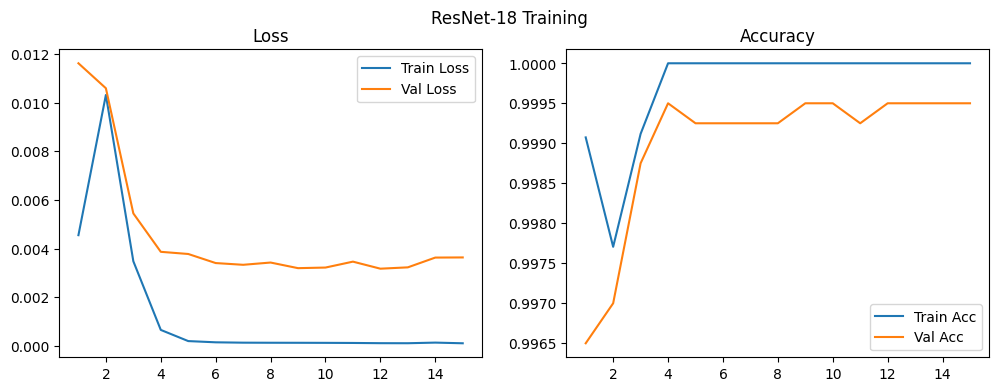

In [ ]:
history_resnet = train_model(resnet18, train_loader, val_loader, epochs=15)
plot_history(history_resnet, "ResNet-18 Training")


In [ ]:
def evaluate(model, loader):
    # Put the model in evaluation mode (disables dropout, uses running stats for batch norm)
    model.eval()
    preds, labels = [], []

    # We don't need gradients for evaluation, so disable them to save memory and time
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)  # forward pass

            # Take the index of the maximum logit as the predicted class
            preds.extend(logits.argmax(1).cpu().numpy())
            # Store the true labels as a NumPy array
            labels.extend(yb.numpy())

    # Compute overall classification accuracy on this loader (e.g., test set)
    acc = accuracy_score(labels, preds)
    print(f"Test Accuracy: {acc:.4f}")

    # Print a detailed per-class precision/recall/F1 report
    print(classification_report(labels, preds, digits=4))

    return acc, labels, preds

# Evaluate the fine-tuned ResNet-18 model on the held-out test set
acc_resnet, y_true, y_pred = evaluate(resnet18, test_loader)


Test Accuracy: 0.9895
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     0.9917    1.0000    0.9959       720
           2     0.9987    0.9947    0.9967       750
           3     1.0000    0.9844    0.9922       450
           4     1.0000    0.9939    0.9970       660
           5     0.9442    0.9937    0.9683       630
           6     1.0000    0.9867    0.9933       150
           7     0.9912    0.9978    0.9945       450
           8     0.9953    0.9333    0.9633       450
           9     0.9876    0.9979    0.9927       480
          10     1.0000    1.0000    1.0000       660
          11     0.9602    0.9762    0.9681       420
          12     1.0000    1.0000    1.0000       690
          13     0.9917    0.9972    0.9945       720
          14     0.9712    1.0000    0.9854       270
          15     1.0000    0.9905    0.9952       210
          16     1.0000    1.0000    1.0000       150
     

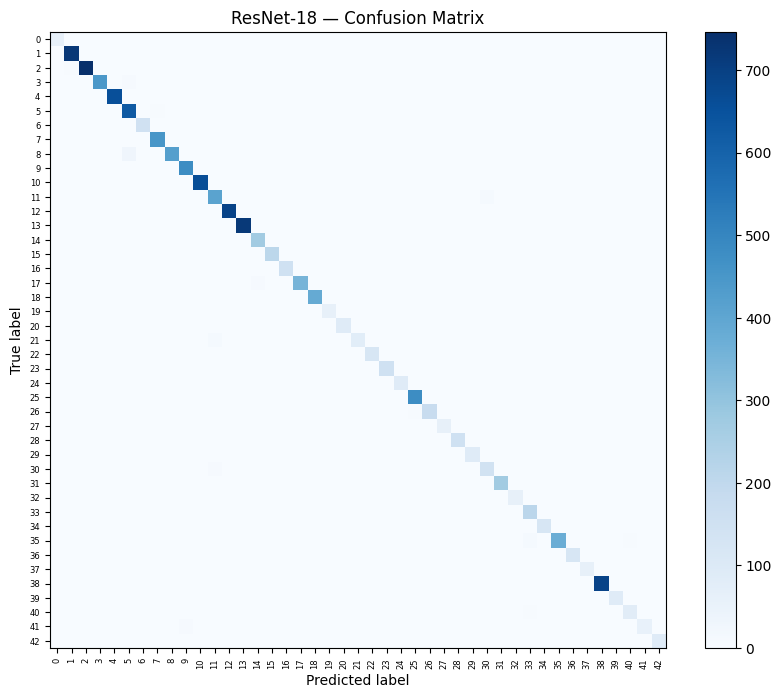

In [ ]:
# Compute the confusion matrix using true and predicted labels
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

# ConfusionMatrixDisplay handles plotting the matrix nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    include_values=False,   # hide raw numbers to keep the plot visually clean
    cmap="Blues",           # blue color map for intensity
    ax=plt.gca(),
    colorbar=True
)

plt.title("ResNet-18 — Confusion Matrix")
plt.xticks(rotation=90, fontsize=6)  # rotate x-axis labels so they don't overlap
plt.yticks(fontsize=6)
plt.show()


In [ ]:
import pandas as pd

# Create a small summary table for the final ResNet-18 model performance
df = pd.DataFrame([
    {"Model": "ResNet-18 (Transfer Learning)", "Test Accuracy": acc_resnet},
])

# Print the table in a clean, readable format (no index column)
print(df.to_string(index=False))


                        Model  Test Accuracy
ResNet-18 (Transfer Learning)       0.989549


In [ ]:
!pip install torch torchvision scikit-learn matplotlib -q

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import random, os, cv2
import torch.nn.functional as F

# Set device + random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
# Basic transform for initial dataset loading:
# resize all images to 64x64 and convert them to tensors.
# This is mainly used to work with labels and indices (e.g., for train/val split).
basic_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

root = "./gtsrb_data"

# Load the full GTSRB training split with the simple 64x64 transform
train_full = datasets.GTSRB(
    root=root,
    split="train",
    download=True,
    transform=basic_tfm
)

# Load the full GTSRB test split (will later be used with a ResNet-specific transform)
test_full = datasets.GTSRB(
    root=root,
    split="test",
    download=True,
    transform=basic_tfm
)

print("Train images:", len(train_full))
print("Test images:", len(test_full))


100%|██████████| 187M/187M [00:08<00:00, 21.9MB/s]
100%|██████████| 89.0M/89.0M [00:04<00:00, 18.8MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 221kB/s]


Train images: 26640
Test images: 12630


In [ ]:
# ----- Create train/validation split (85% train, 15% validation) -----

# Create a list of all indices in the training set
indices = np.arange(len(train_full))

# Shuffle the indices so the split is random
np.random.shuffle(indices)

# Use 15% of the data for validation, 85% for training
val_len = int(0.15 * len(indices))
val_idx = indices[:val_len]      # first 15% → validation
train_idx = indices[val_len:]    # remaining 85% → training

print("Train size:", len(train_idx))
print("Validation size:", len(val_idx))


Train size: 22644
Validation size: 3996


In [ ]:
# ----- Transforms for ResNet-18: training vs. test/validation -----

# Training transform:
# - Resize to 224x224 to match ResNet-18's expected input size
# - Apply light data augmentation (rotation, color jitter, horizontal flip)
#   to make the model more robust to real-world variations
# - Normalize using ImageNet mean/std so the pretrained weights work well
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),                         # small random rotations (±10 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # slight brightness/contrast changes
    transforms.RandomHorizontalFlip(p=0.2),               # randomly flip some images
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],  # ImageNet mean
        [0.229, 0.224, 0.225]   # ImageNet std
    )
])

# Test/validation transform:
# - Same resize + normalization, but NO augmentation
#   so evaluation is done on clean, deterministic images
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],  # ImageNet mean
        [0.229, 0.224, 0.225]   # ImageNet std
    )
])


In [ ]:
# Reload GTSRB with the new transforms:
# - train_resnet uses train_tfm (with augmentation)
# - test_resnet  uses test_tfm  (no augmentation)
train_resnet = datasets.GTSRB(
    root=root,
    split="train",
    download=False,      # already downloaded earlier
    transform=train_tfm
)

test_resnet = datasets.GTSRB(
    root=root,
    split="test",
    download=False,
    transform=test_tfm
)

# Use the SAME train/validation indices as before,
# but now applied on the ResNet-transformed version of the dataset.
train_subset = Subset(train_resnet, train_idx)
val_subset   = Subset(train_resnet, val_idx)

print("Loaded transformed subsets:")
print("Train subset:", len(train_subset))
print("Val subset:", len(val_subset))
print("Test set:", len(test_resnet))


Loaded transformed subsets:
Train subset: 22644
Val subset: 3996
Test set: 12630


In [ ]:
# Mini-batch size used during training and evaluation
BATCH_SIZE = 128

# DataLoader for training:
# - uses augmented training subset
# - shuffle=True to randomize sample order each epoch
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# DataLoader for validation:
# - no shuffling to keep evaluation deterministic
val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# DataLoader for test set:
# - also no shuffling; used only for final evaluation
test_loader = DataLoader(
    test_resnet,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Batches — Train:", len(train_loader), "Val:", len(val_loader), "Test:", len(test_loader))


Batches — Train: 177 Val: 32 Test: 99


In [ ]:
# ----- Load pretrained ResNet-18 for transfer learning -----
# Start from a ResNet-18 model pretrained on ImageNet.
# This gives us a strong feature extractor for general visual patterns.
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_classes = 43  # Number of traffic sign classes in GTSRB

# Replace the original 1000-class ImageNet classifier with a new 43-class head.
# This is the only layer we change in the ResNet architecture.
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to GPU if available (or CPU otherwise)
resnet18 = resnet18.to(device)

print("Model Loaded: ResNet-18")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


Model Loaded: ResNet-18


In [ ]:
def train_model(model, train_loader, val_loader, epochs=8, lr=1e-4, weight_decay=1e-4):
    # Adam optimizer with a small learning rate and L2 regularization (weight_decay)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Cross-entropy loss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Store metrics over epochs for plotting later
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        # ----- TRAINING PHASE -----
        model.train()  # enable training mode (dropout, batchnorm updates)
        total_loss, correct, total = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()         # clear old gradients
            logits = model(xb)            # forward pass
            loss = criterion(logits, yb)  # compute loss
            loss.backward()               # backpropagate
            optimizer.step()              # update model parameters

            # Track cumulative training loss and accuracy
            total_loss += loss.item() * yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # ----- VALIDATION PHASE -----
        model.eval()  # switch to evaluation mode
        v_total, v_correct, v_loss_sum = 0, 0, 0

        # No gradient computation during validation
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                v_loss_sum += loss.item() * yb.size(0)
                v_correct += (logits.argmax(1) == yb).sum().item()
                v_total += yb.size(0)

        val_loss = v_loss_sum / v_total
        val_acc = v_correct / v_total

        # Save metrics for this epoch
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print a short training summary line
        print(f"Epoch {epoch:02d}: TrainAcc={train_acc:.3f}, ValAcc={val_acc:.3f}")

    return history


In [ ]:
def plot_history(history, title="Training History"):
    # Extract list of epoch numbers for the x-axis
    epochs = history["epoch"]
    plt.figure(figsize=(12, 4))

    # ---- Plot training vs validation loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()

    # ---- Plot training vs validation accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.title("Accuracy")
    plt.legend()

    # Overall title (e.g., "ResNet-18 with Augmentation")
    plt.suptitle(title)
    plt.show()


Epoch 01: TrainAcc=0.841, ValAcc=0.982
Epoch 02: TrainAcc=0.992, ValAcc=0.993
Epoch 03: TrainAcc=0.997, ValAcc=0.994
Epoch 04: TrainAcc=0.998, ValAcc=0.997
Epoch 05: TrainAcc=0.999, ValAcc=0.997
Epoch 06: TrainAcc=0.999, ValAcc=0.997
Epoch 07: TrainAcc=0.999, ValAcc=0.997
Epoch 08: TrainAcc=0.999, ValAcc=0.997


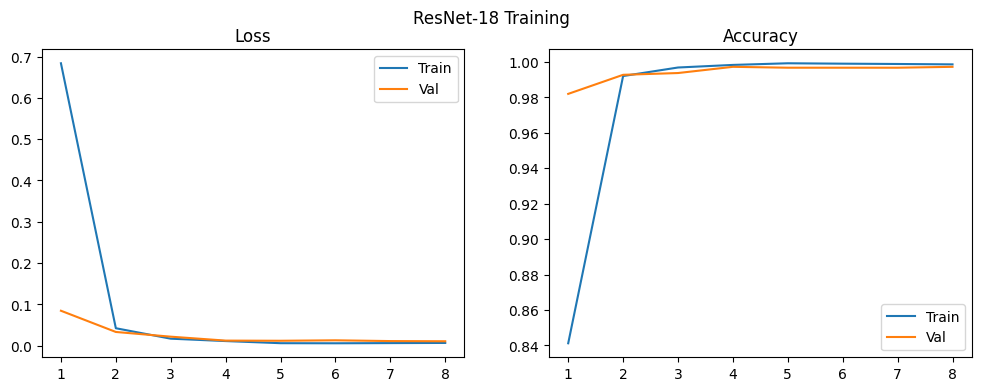

In [ ]:
# Train the ResNet-18 model on the augmented training set
# and track performance on the validation set over 8 epochs
history = train_model(resnet18, train_loader, val_loader, epochs=8)

# Plot training vs validation loss and accuracy curves
plot_history(history, "ResNet-18 Training")


In [ ]:
def evaluate(model, loader):
    # Switch model to evaluation mode (disables dropout, uses running stats for batch norm)
    model.eval()
    preds, labels = [], []

    # Disable gradient computation during evaluation for efficiency
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)  # forward pass

            # Predicted class is the index of the max logit
            preds.extend(logits.argmax(1).cpu().numpy())
            # Store ground-truth labels as NumPy array
            labels.extend(yb.numpy())

    # Compute overall accuracy
    acc = accuracy_score(labels, preds)
    print("Test Accuracy:", acc)

    # Print detailed per-class precision, recall, and F1-score
    print(classification_report(labels, preds))

    return acc, labels, preds

# Evaluate the fine-tuned ResNet-18 model on the held-out test set
acc_resnet, y_true, y_pred = evaluate(resnet18, test_loader)


Test Accuracy: 0.9690419635787807
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.97      0.99      0.98       630
           6       0.99      0.99      0.99       150
           7       0.99      1.00      0.99       450
           8       1.00      0.96      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.98      0.98      0.98       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00    

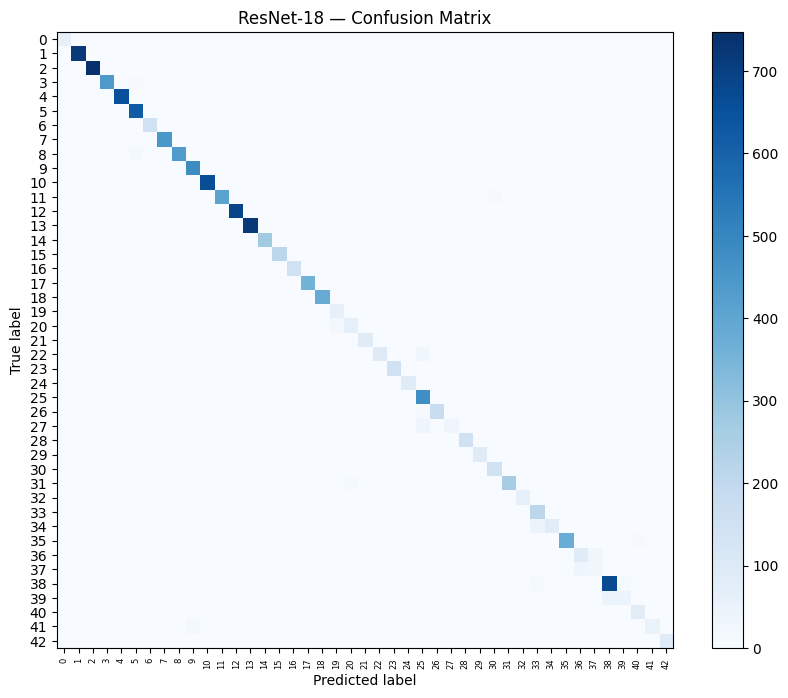

In [ ]:
# Compute confusion matrix from true and predicted labels
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

# Use ConfusionMatrixDisplay to visualize class-wise performance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    include_values=False,   # hide numeric values to keep the plot visually clean
    cmap="Blues",
    ax=plt.gca(),
    colorbar=True
)

plt.title("ResNet-18 — Confusion Matrix")
plt.xticks(rotation=90, fontsize=6)  # rotate class labels so they don't overlap
plt.show()


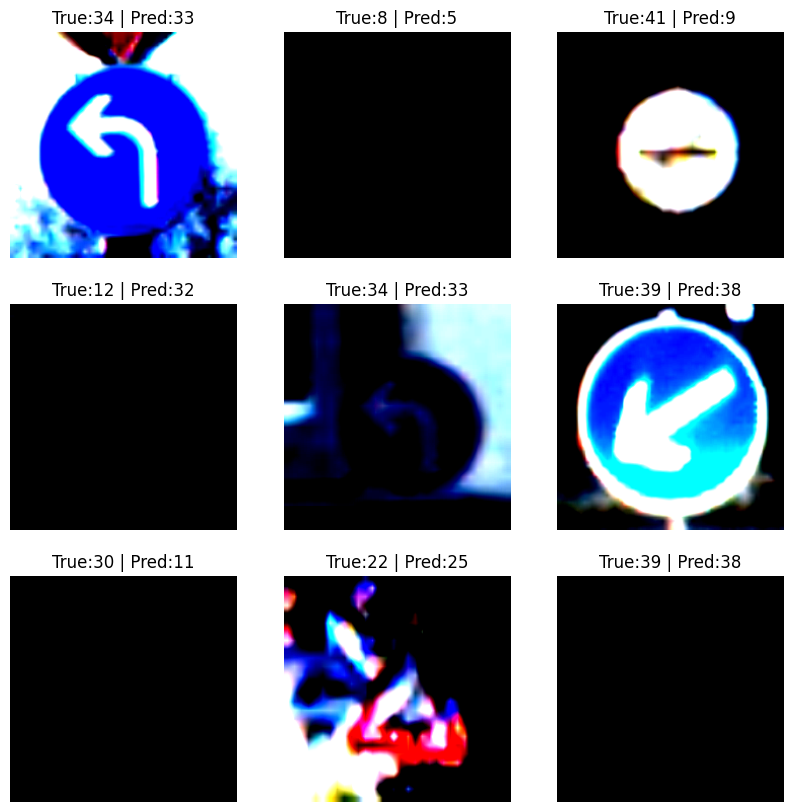

In [ ]:
# ----- Collect a few misclassified test examples -----
misclassified = []

for img, label in test_resnet:
    # Add batch dimension and move to device
    img_tensor = img.unsqueeze(0).to(device)
    # Forward pass through the trained ResNet-18
    pred = resnet18(img_tensor).argmax(1).item()

    # Store (image, true_label, predicted_label) if the model is wrong
    if pred != label:
        misclassified.append((img, label, pred))

    # Stop after collecting 9 examples to make a 3x3 grid
    if len(misclassified) == 9:
        break

# ----- Visualize misclassified samples -----
plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(misclassified):
    plt.subplot(3, 3, i + 1)
    # Convert from (C, H, W) tensor to (H, W, C) for imshow
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True:{label} | Pred:{pred}")
    plt.axis("off")

plt.show()


In [ ]:
def grad_cam_resnet(model, img_tensor):
    # Put model in evaluation mode for Grad-CAM computation
    model.eval()

    # We will compute Grad-CAM on the last block of layer4,
    # which has the highest-level semantic features.
    target_layer = model.layer4[-1]   # last BasicBlock of layer4

    activations = []  # will store forward feature maps from target_layer
    gradients = []    # will store gradients w.r.t. those feature maps

    # Forward hook: captures the output (feature maps) of target_layer
    def forward_hook(module, input, output):
        activations.append(output)

    # Backward hook: captures gradients flowing back through target_layer
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks so they run during forward and backward passes
    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_full_backward_hook(backward_hook)

    # ----- Forward pass -----
    # img_tensor is a single image (C, H, W); add batch dimension
    output = model(img_tensor.unsqueeze(0))
    # Predicted class index (we generate Grad-CAM for this class)
    pred_class = output.argmax().item()

    # ----- Backward pass -----
    model.zero_grad()
    # Backpropagate only the score of the predicted class
    output[0, pred_class].backward()

    # Remove hooks to avoid memory leaks / side effects
    fh.remove()
    bh.remove()

    # Extract the feature maps and gradients captured by the hooks
    activ = activations[0][0]        # shape: (C, H, W)
    grads  = gradients[0][0]         # shape: (C, H, W)

    # Global Average Pooling over gradients to get a weight per channel
    weights = grads.mean(dim=(1, 2))  # shape: (C,)

    # Ensure activations are on the same device as the weights
    activ = activ.to(weights.device)

    # Initialize the Class Activation Map (CAM) on the right device
    cam = torch.zeros(activ.shape[1:], dtype=torch.float32, device=weights.device)

    # Weighted sum of feature maps: sum_c (w_c * A_c)
    for w, a in zip(weights, activ):
        cam += w * a

    # Apply ReLU: we only care about features that have a positive influence
    cam = cam.clamp(min=0).detach().cpu().numpy()

    # Normalize CAM to [0, 1]
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # Resize CAM to match the input image size (224 x 224)
    cam = cv2.resize(cam, (224, 224))

    return cam, pred_class


In [ ]:
def show_grad_cam(img_tensor):
    # Compute Grad-CAM heatmap and predicted class for a single image
    cam, pred = grad_cam_resnet(resnet18, img_tensor.to(device))

    # Convert image tensor (C, H, W) → (H, W, C) and normalize to [0, 1] for display
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() + 1e-8)

    # Convert CAM (in [0,1]) to a color heatmap using OpenCV's JET colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # OpenCV gives BGR; convert to RGB and scale to [0,1]

    # Blend original image and heatmap: 0.6 * image + 0.4 * heatmap
    # This shows both the underlying sign and where the model is focusing.
    overlay = 0.6 * img + 0.4 * heatmap

    # Show original image vs Grad-CAM overlay side by side
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.show()


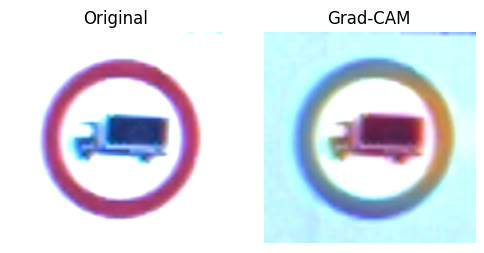

In [ ]:
# Pick one sample test image and visualize its Grad-CAM explanation
sample_img, _ = test_resnet[0]
show_grad_cam(sample_img)


In [ ]:
def evaluate_model_accuracy(model, test_loader):
    # Put the model in evaluation mode
    model.eval()
    preds, labels = [], []

    # Disable gradients during evaluation for efficiency
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)  # forward pass

            # Collect predicted class indices and true labels
            preds.extend(logits.argmax(1).cpu().numpy())
            labels.extend(yb.numpy())

    # Compute overall test accuracy
    acc = accuracy_score(labels, preds)
    print("Test Accuracy:", round(acc, 4))
    return acc

# Run accuracy evaluation for the improved ResNet-18 setup
accuracy_improved = evaluate_model_accuracy(resnet18, test_loader)
print("Final Improved ResNet-18 Accuracy:", accuracy_improved)


Test Accuracy: 0.969
Final Improved ResNet-18 Accuracy: 0.9690419635787807
